<a href="https://colab.research.google.com/github/iqbalfikdata/CLUSTERING/blob/master/Cencus_Income_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import xgboost as xgb, lightgbm as lgb, csv
#from catboost import CatBoostClassifier, Pool, cv
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier, BaggingClassifier, \
ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from mlxtend.classifier import EnsembleVoteClassifier, StackingClassifier

#from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, \
StratifiedShuffleSplit
from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials, space_eval
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.manifold import MDS, LocallyLinearEmbedding, Isomap, TSNE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.base import BaseEstimator, TransformerMixin

from keras.models import Sequential
from keras.layers import Dense, AlphaDropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.optimizers import Nadam, SGD
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from tensorflow.python.keras import backend as K

import numpy as np, pandas as pd, seaborn as sns, os, requests
from matplotlib import pyplot as plt, cm
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, auc, plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')
#from ast import literal_eval
import time
from numpy import log
#from itertools import combinations as C

pd.options.display.max_colwidth = 500
%matplotlib inline
print('Aku siap \U0001F600')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


Aku siap 😀


In [2]:
def load_dataset(path, urls):
  if not os.path.exists(path):
    os.mkdir(path)
  for url in urls:
    data = requests.get(url).content
    filename = os.path.join(path, os.path.basename(url))
    with open(filename, 'wb') as file:
      file.write(data)

urls = ['http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
        'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names',
        'http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test']
load_dataset('data_ku', urls)

In [3]:
columns = ["age", "workClass", "fnlwgt", "education", "education-num","marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
train_data = pd.read_csv('/content/data_ku/adult.data', names=columns, 
             sep=' *, *', na_values='?')
test_data  = pd.read_csv('/content/data_ku/adult.test', names=columns, 
             sep=' *, *', skiprows=1, na_values='?')

train_data = train_data.sample(5000, random_state=2020)
test_data = test_data.sample(2000, random_state=2020)

In [4]:
mulai = time.time()

train_data['PersonID'] = range(1, train_data.shape[0] + 1)
train_data.set_index('PersonID', inplace=True)
traindex = train_data.index

test_data['PersonID'] = range(train_data.shape[0] + 1, train_data.shape[0] + test_data.shape[0] + 1)
test_data.set_index('PersonID', inplace=True)
testdex = test_data.index

data = pd.concat([train_data, test_data], 0)
data.drop('fnlwgt', 1, inplace=True)

In [5]:
#Memisahkan tabel kategori dan numerik
cat_data = data.select_dtypes(include='object')
num_data = data.select_dtypes(include=np.number)

In [6]:
#Function utk membuat tabel kategori yang berisikan unique value dan jumlahnya

def unique(df):
    k = []
    for i in df.columns:
        df_unique = pd.DataFrame()
        unique = df[i].unique()
        null = df[i].isnull().sum()
        dfnew = pd.DataFrame({'%s [unique: %d, null: %d]'%
                              (i,len(unique),null):unique})
        df_unique = pd.concat([df_unique, dfnew], 1)
        k.append(df_unique)
    for i in k:
        df_unique = pd.concat([df_unique, i], 1)
    return df_unique.iloc[:, 1:]

df_unique = unique(cat_data)
df_unique.head()

,"workClass [unique: 8, null: 406]","education [unique: 16, null: 0]","marital-status [unique: 7, null: 0]","occupation [unique: 15, null: 406]","relationship [unique: 6, null: 0]","race [unique: 5, null: 0]","sex [unique: 2, null: 0]","native-country [unique: 41, null: 129]","income [unique: 4, null: 0]"
0,Local-gov,11th,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States,<=50K
1,Private,Some-college,Never-married,Adm-clerical,Own-child,Black,Female,Hungary,>50K
2,Self-emp-not-inc,Bachelors,Divorced,Craft-repair,Not-in-family,Asian-Pac-Islander,NaN,Philippines,>50K.
3,NaN,HS-grad,Widowed,Prof-specialty,Unmarried,Amer-Indian-Eskimo,NaN,China,<=50K.
4,Self-emp-inc,10th,Separated,Exec-managerial,Other-relative,Other,NaN,Mexico,NaN


In [7]:
def fill_missing_value(df, columns, statistic=None):
  for i in columns:
    if statistic == 'mode':
      df[i] = df[i].fillna(df[i].mode()[0])
    elif statistic == 'median':
      df[i] = df[i].fillna(np.round(df[i].median(), 2))
    else:
      df[i] = df[i].fillna(np.round(df[i].mean(), 2))
  return df

columns = ['workClass', 'occupation', 'native-country']
fill_missing_value(data, columns, statistic='mode').sample(n=3)

,age,workClass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
PersonID,,,,,,,,,,,,,,
5765,52,Federal-gov,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,>50K.
2151,39,Private,Doctorate,16,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,45,United-States,<=50K
5513,36,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,>50K.


In [8]:
education_levels = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th',
                    'HS-grad', 'Prof-school', 'Assoc-acdm', 'Assoc-voc', 'Some-college', 'Bachelors',
                    'Masters', 'Doctorate']
levels = list(range(1, len(education_levels) + 1, 1))
education_dict = {}
for i, j in zip(education_levels, levels):
  education_dict[i] = j
data['education'] = data['education'].map(education_dict)

data['sex'] = data['sex'].map({'Female' : 0, 'Male' : 1})
data['income'] = data.income.replace({'<=50K.' : '<=50K', '>50K.' : '>50K'})
#data['income'] = data.income.map({'<=50K' : 0, '>50K' : 1})

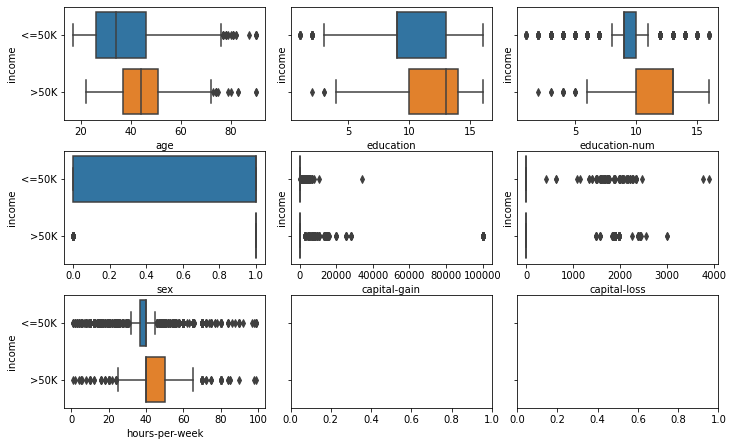

In [9]:
#Melihat raw data yang diluar rentang 1,5 IQR

data_num = data.select_dtypes(include=np.number)
num_cols = data_num.columns
fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharey=True)
for num_col, ax in zip(num_cols, axes.flat):
  sns.boxplot(x=num_col, y='income', data=data.loc[traindex, :], ax=ax)
plt.tight_layout(pad=0)

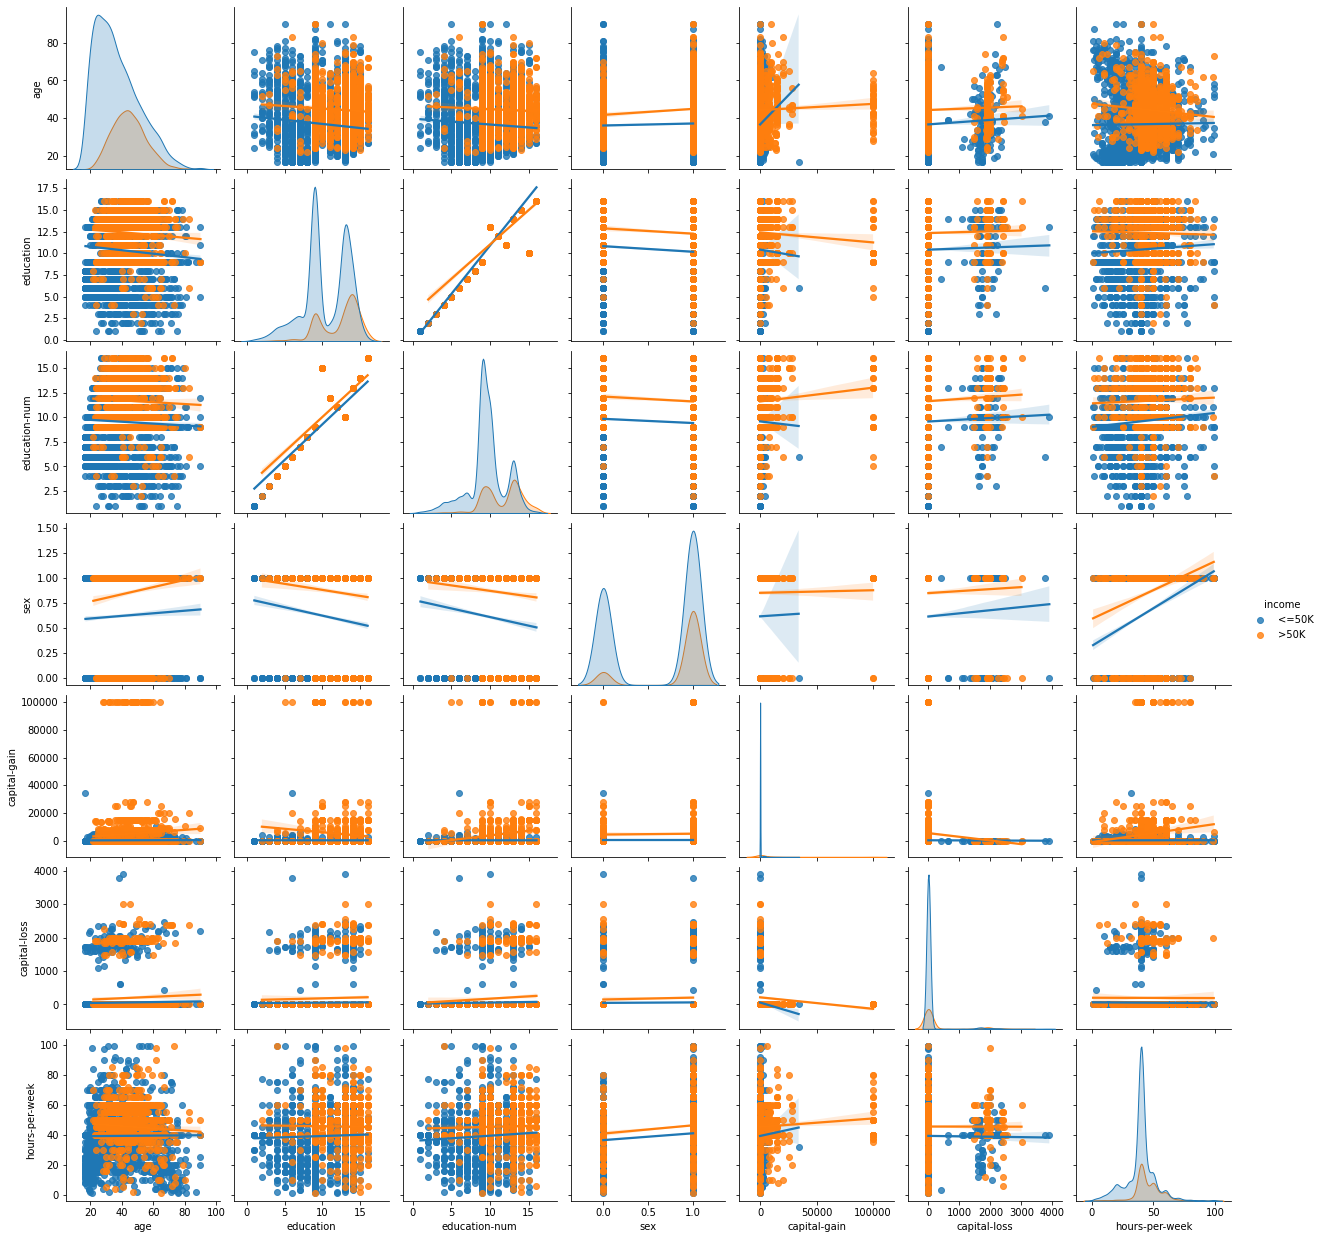

In [10]:
#Melihat scatter antar variable dan PDF tiap variable tsb

sns.pairplot(
    data.loc[traindex, :], hue='income', kind='reg')

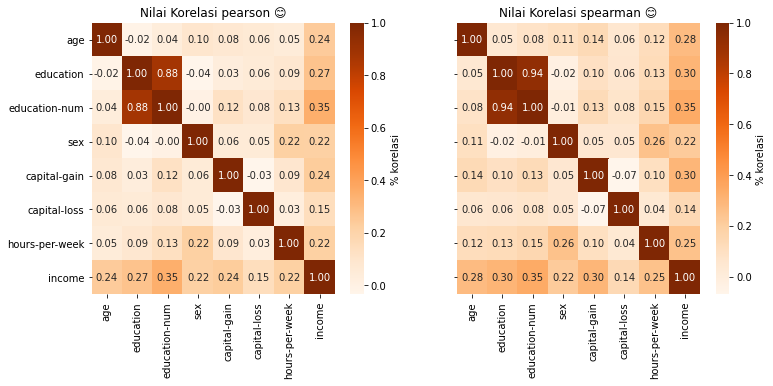

In [11]:
#Terlihat bahwa education-num dan education sepertinya memiliki nilai korelasi yang tinggi

#selanjutnya Kita ingin tahu terlebih korelasi antar tiap variable

data['income'] = data.income.map({'<=50K' : 0, '>50K' : 1})
methods = ['pearson', 'spearman']
fig, axes = plt.subplots(1, 2, figsize=[12, 5], sharey=True)

for ax, method in zip(axes, methods):
  corr = data.loc[traindex, :].corr(method=method)
  sns.heatmap(corr, annot=True, fmt='.2f', cmap='Oranges', cbar_kws={'label':'% korelasi'}, ax=ax)
  ax.set_title('Nilai Korelasi %s \U0001F60A'%(method))

In [12]:
#Terlihat bahwa kolom education dan education-num memiliki korelasi yang cuku tinggi, ke depan kita
# akan drop saja
data.drop('education-num', 1, inplace=True)

#Memberikan variable dummy pada kolom [workClass, marital-status, occupation, relationship, race, native-country]
OneHotCols = [i for i in cat_data.columns if i not in ['education', 'sex', 'income']]
data = pd.get_dummies(columns=OneHotCols, data=data)

#Menyeragamkan kolom [Age, edicatoion, capital-gain/loss, hours-per-week]
ScalerCols = [i for i in data_num.columns if i not in ['sex', 'education-num']]
data[ScalerCols] = (data[ScalerCols] - data[ScalerCols].mean()) / data[ScalerCols].std()

In [13]:
#Feature Enginering nya sudah selesai, sekarang mari kita pisahkan train dari test data nya

dftrain = data.loc[traindex, :]
dftest = data.loc[testdex, :]
income = dftrain['income']
dftest.drop('income', 1, inplace=True)

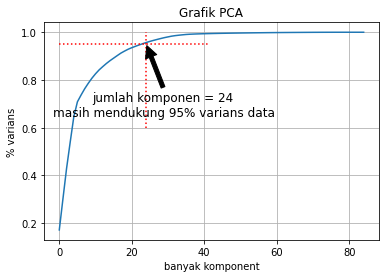

(Text(0.5, 1.0, 'Grafik PCA'), None, None)

In [14]:
predictors = [i for i in data.columns if i not in ['income']]
X = dftrain.loc[:, predictors]
y = dftrain.loc[:, 'income']

pca = PCA(n_components=.95)
pca1 = PCA().fit(X)
X_pca = pca.fit_transform(X)

plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.annotate(
    'jumlah komponen = {} \nmasih mendukung 95% varians data'.format(X_pca.shape[1]), xy=(X_pca.shape[1], .95),
    xytext = (X_pca.shape[1]+5, .65), arrowprops=dict(facecolor='black', shrink=.03),
    fontsize=12, ha='center'
)
plt.plot([0, 41], [.95, .95], 'r:')
plt.plot([X_pca.shape[1], X_pca.shape[1]], [0.6, 1], 'r:')
plt.xlabel('banyak komponent')
plt.ylabel('% varians')
plt.title('Grafik PCA'), plt.grid(), plt.show()

In [15]:
print('Persentase tiap kelas')
print(np.round(y.value_counts(normalize = True) * 100, 2))
imbalance_weight = y.value_counts()[0] / y.value_counts()[1] 
print('imbalance weight = {:.2f}'.format(imbalance_weight))
if imbalance_weight > 2. :
  print('wah data nya Lumayan tidak seimbang \U0001F602')
else: print('data nya masih seimbang')

Persentase tiap kelas
0    75.84
1    24.16
Name: income, dtype: float64
imbalance weight = 3.14
wah data nya Lumayan tidak seimbang 😂


- Membagi data menjadi data training dan data testing
- Menggunakan cross validation yang membagi data menjadi 5 bagian (fold)

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.2, random_state=0)
Xtrain_pca, Xtest_pca, ytrain, ytest = train_test_split(X_pca, y, stratify=y, test_size=.2, random_state=0)
cv = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=0)

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'r','g', 'b', 'c', 'y']
colors = colors + colors
cmaps  = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'Greys',
          'Blues', 'cool', 'hot', 'autumn', 'inferno', 'magma', 'cividis', 'viridis']
cmaps = cmaps + cmaps
Blues_r = cm.get_cmap('Blues_r')

Inisialisasi base model

In [17]:
KNN, svc, DTC = KNeighborsClassifier(), SVC(), DecisionTreeClassifier()
RFC, ABC = RandomForestClassifier(random_state=0), AdaBoostClassifier(random_state=0)
BAG, SGDC = BaggingClassifier(base_estimator=DTC), SGDClassifier()
LR, GBC = LogisticRegression(), GradientBoostingClassifier()
GNB = GaussianNB()
ETC = ExtraTreesClassifier()

Membuat base model untuk LightGBM dan XGBoost

In [18]:
lgb_clf = lgb.LGBMClassifier(is_unbalance=True)
lgtrain = lgb.Dataset(Xtrain_pca, ytrain)
lg_hyparams = lgb_clf.get_params()

#Tidak perlu menggunakan n_estimators karena kita akan menentukannya dengan tehnik early_stopping
del lg_hyparams['n_estimators']
lgb_cv = lgb.cv(lg_hyparams, lgtrain, num_boost_round=10000, early_stopping_rounds=100,
                nfold=5, seed=1, metrics='auc')
#best_cv_lg = lgb_cv['auc-mean'][-1]
opt_estimators_lg = len(lgb_cv['auc-mean'])
lgb_clf.n_estimators = opt_estimators_lg

xgtrain = xgb.DMatrix(Xtrain_pca, ytrain)
xgb_clf = xgb.XGBClassifier()
xgb_hyparams = {
    'objective' : 'binary:logistic', 'seed':1, 'scale_pos_weight':imbalance_weight, 'eta':0.05}
xgb_cv = xgb.cv(xgb_hyparams, xgtrain, num_boost_round=10000, early_stopping_rounds=100,
                metrics='auc', nfold=5)
opt_estimators_xg = xgb_cv.shape[0]
xgb_clf.n_estimators = opt_estimators_xg

Memberi nama / melabeli tiap model

In [19]:
def get_models(model_list):
  models_dict = {}
  for model in model_list:
    if 'voting' in dir(model):
      models_dict['%d-%s-%s'%(len(model.named_clfs), model.voting, str(model)[:22])] = model
    elif 'meta_classifier' in dir(model):
      models_dict['%d %s meta-%s'%(len(model.named_classifiers), str(model)[:5],
                              model.meta_classifier.__class__.__name__)] = model
    else:
      models_dict[model.__class__.__name__] = model
  return models_dict

Membuat function yang me-return nilai performa (akurasi) dari tiap base model

lama waktu eksekusi 0.61 menit


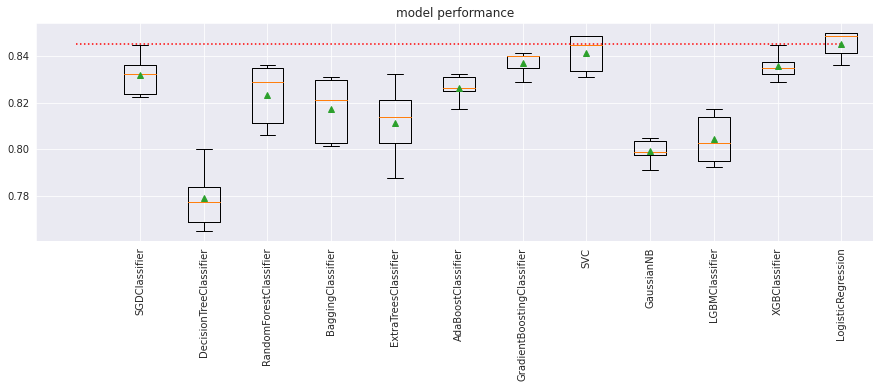

In [20]:
def boxplot_model(models, X, y):
  global rank_models
  rank_models = pd.DataFrame(columns=['Model Name', 'Model', 'Train_CV_acc', 'Test_acc',
                                      'Precision Test'])
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, test_size=.2, random_state=2020)
  cv_train, test_acc, test_precision, model_names,  = [], [], [], []
  cv_train_means = []
  plt.figure(figsize = (15, 4))
  for label in models:
    cv_score = cross_val_score(models[label], Xtrain, ytrain, cv=cv, scoring='accuracy')
    cv_train.append(cv_score)
    cv_train_means.append(cv_score.mean())
    models[label].fit(Xtrain, ytrain)
    ypred = models[label].predict(Xtest)
    akurasi = np.round(accuracy_score(ytest, ypred), 3)
    presisi = np.round(precision_score(ytest, ypred, average='binary'), 3)
    test_acc.append(akurasi), test_precision.append(presisi)
    model_names.append(label)

    rank_models = rank_models.append({
      'Model Name' : label, 'Model' : models[label],
      'Train_CV_acc' : np.round(cv_score.mean(), 3), 'Test_acc' : akurasi, 'Precision Test' : presisi},
      ignore_index = True).sort_values(by='Precision Test', ascending = False)

  sns.set_style('darkgrid')
  plt.boxplot(cv_train, labels=model_names, showmeans=True, )
  plt.plot([0, len(model_names)], [max(cv_train_means), max(cv_train_means)], 'r:')
  plt.title('model performance')
  plt.xticks(rotation=90)

t0 = time.time()
base_models = [SGDC, DTC, RFC, BAG, ETC, ABC, GBC, svc, GNB, lgb_clf, xgb_clf, LR]
base_models = get_models(base_models)
boxplot_model(base_models, X_pca, y)
print('lama waktu eksekusi {:.2f} menit'.format((time.time() - t0) / 60))

In [21]:
#Melihat peringkat base model berdasarkan nilai presisi nya
rank_models.iloc[:, [0, 2, 3, 4]]

,Model Name,Train_CV_acc,Test_acc,Precision Test
0,SVC,0.841,0.866,0.767
1,XGBClassifier,0.836,0.861,0.737
2,RandomForestClassifier,0.824,0.854,0.735
3,GradientBoostingClassifier,0.837,0.855,0.730
4,ExtraTreesClassifier,0.812,0.844,0.707
5,BaggingClassifier,0.817,0.842,0.702
11,LogisticRegression,0.845,0.847,0.700
6,AdaBoostClassifier,0.826,0.844,0.699
7,SGDClassifier,0.832,0.837,0.676
8,LGBMClassifier,0.804,0.833,0.613


**Membuat model machine learning**
1. Mendefinisikan rentang hyperparameter dari tiap model
2. Men-tuning hyperparameter nya menggunakan Bayesian Optimizer (hyperopt) dan RandomizedSearchCV
3. Membangun model machine learning dengan menggunakan hyperparameter yang telah didapatkan

In [22]:
#Memastikan bahwa Hyperparameter tententu harus beruapa bilangan bulat
int_hyparams = ['max_depth', 'n_estimators', 'max_features', 'min_samples_split',
                'num_leaves', 'subsample_for_bin', 'min_child_samples', 'min_child_weight']

#Membuat class yang akan mereturn hyperparameter terbaik dari tiap model
class BayesianOptimizer():
  def __init__(self, X, y, model, model_params):
    self.X, self.y = X, y
    self.model, self.model_params = model, model_params    
    self.Xtrain, self.Xtest, self.ytrain, self.ytest = train_test_split(
        self.X, self.y, stratify=self.y, test_size=.2, random_state=2020)
  def objective(self, hyparams):
    cv_results = cross_val_score(self.model, self.Xtrain, self.ytrain, cv=cv, scoring='accuracy')
    loss = 1 - cv_results.mean()
    try:
      return {'loss' : loss, 'status' : STATUS_OK}
    except Exception as e:
      return {'status' : STATUS_FAIL, 'except' : str(e)}
  def Fmin(self):
    trials = Trials()
    if self.model in [svc, GBC]:
      best_params = fmin(fn=self.objective, space=self.model_params, algo=tpe.suggest, max_evals=3)
    elif self.model is ABC:
      best_params = fmin(fn=self.objective, space=self.model_params, algo=tpe.suggest, max_evals=3)
    else:
      best_params = fmin(fn=self.objective, space=self.model_params, algo=tpe.suggest, max_evals=3)
      best_params = space_eval(self.model_params, best_params)
    for i in best_params:
      if i in int_hyparams:
        best_params[i] = int(best_params[i])
    return best_params

In [23]:
#2. Mentuning Hyperparameter nya

t0 = time.time()
#1
LR_penalty = hp.choice('penalty',
    [{'penalty' : 'l1', 'solver' : hp.choice('solver_l1', ['liblinear', 'saga'])},
     {'penalty' : 'l2', 'solver' : hp.choice('solver_l2', ['newton-cg', 'lbfgs', 'sag', 'saga'])},
     {'penalty' : 'elasticnet', 'solver' : 'saga'}])
LR_space = {'penalty' : LR_penalty,
            'C' : hp.loguniform('C', np.log(.1), np.log(10)),
            'l1_ratio' : hp.uniform('l1_ratio', .0, 1.0),
            'class_weight' :'balanced'}
LR_bayes = BayesianOptimizer(X_pca, y, LR, LR_space)
best_LR = LR_bayes.Fmin()

#2
SGD_penalty = ['l1', 'l2', 'elasticnet']
#SGD_loss = ['log', 'modified_huber']
SGD_space = {'l1_ratio' : hp.uniform('l1_ratio', .0, 1.0),
             'penalty' : hp.choice('penalty', SGD_penalty),
             'alpha' : hp.loguniform('alpha', np.log(.01), np.log(.5))}
SGD_bayes = BayesianOptimizer(X_pca, y, SGDC, SGD_space)
best_SGD = SGD_bayes.Fmin()

#3
DTC_space = {'max_depth' : hp.quniform('max_depth', 3, 15, 1),
             'max_features' : hp.quniform('max_features', 3, Xtrain_pca.shape[1]-3, 3)}
DTC_bayes = BayesianOptimizer(X_pca, y, DTC, DTC_space)
best_DTC = DTC_bayes.Fmin()

#4
RFC_bootstrap = [False, True]
RFC_space = {'max_depth' : hp.quniform('max_depth', 3, 15, 1),
             'max_features' : hp.quniform('max_features', 3, Xtrain_pca.shape[1]-3, 3),
             'bootstrap' : hp.choice('bootstrap', RFC_bootstrap),
             'n_estimators' : hp.quniform('n_estimators', 10, 1001, 100)}
RFC_bayes = BayesianOptimizer(X_pca, y, RFC, RFC_space)
best_RFC = RFC_bayes.Fmin()

#5
BAG_space = {'n_estimators' : hp.quniform('n_estimators', 10, 201, 20),
             'max_features' : hp.quniform('max_features', 3, Xtrain_pca.shape[1]-3, 3)}
BAG_bayes = BayesianOptimizer(X_pca, y, BAG, BAG_space)
best_BAG = BAG_bayes.Fmin()

#6
ETC_bootstrap = [False, True]
ETC_space = {'n_estimators' : hp.quniform('n_estimators', 20, 1001, 100),
             'max_depth' : hp.quniform('max_depth', 3, 15, 1),
             'max_features' : hp.quniform('max_features', 3,  Xtrain_pca.shape[1], 3),
             'min_samples_split' : hp.quniform('min_samples_split', 2, 15, 1),
             'bootstrap' : hp.choice('bootstrap', ETC_bootstrap)}
ETC_bayes = BayesianOptimizer(X_pca, y, ETC, ETC_space)
best_ETC = ETC_bayes.Fmin()

#7
ABC_space = {'n_estimators' : hp.quniform('n_estimators', 10, 1001, 100),
             'learning_rate' : hp.loguniform('learning_rate', np.log(.01), np.log(.5))}
ABC_bayes = BayesianOptimizer(X_pca, y, ABC, ABC_space)
best_ABC = ABC_bayes.Fmin()

#8
GBC_space = {'max_depth': hp.quniform('max_depth', 5, 12, 1),
              'learning_rate':hp.loguniform('learning_rate', np.log(.01), np.log(.2)),
              'max_features' : hp.quniform('max_features', 3, Xtrain_pca.shape[1], 3),
              'min_samples_split' : hp.quniform('min_samples_split', 2, 50, 1),
              'n_estimators' : hp.quniform('n_estimators', 100, 1001, 100)}
GBC_bayes = BayesianOptimizer(X_pca, y, GBC, GBC_space)
best_GBC = GBC_bayes.Fmin()

#9
xgb_space = {'learning_rate' : hp.loguniform('learning_rate', np.log(.01), np.log(.5)),
             'n_estimaors' : hp.quniform('n_estimators', 20, 1001, 30),
             'max_depth' : hp.quniform('max_depth', 5, 16, 1),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 8, 1),
             'colsample_bytree' : hp.uniform('colsample_bytree', .5, 1.),
             'subsample' : hp.uniform('subsample', .5, 1.),
             'objective' : 'binary:logistic', 'eval_metric' : 'auc'}
xgb_bayes = BayesianOptimizer(X_pca, y, xgb.XGBClassifier(), xgb_space)
best_xgb = xgb_bayes.Fmin()

10#
lgb_boosting_type, lgb_is_unbalance = ['gbdt', 'goss', 'dart'], [False, True]
lgb_space = {
'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance' : hp.choice('is_unbalance', [False, True]),
    'n_estimaors' : hp.quniform('n_estimators', 20, 1001, 30)}
lgb_bayes = BayesianOptimizer(X_pca, y, lgb.LGBMClassifier(), lgb_space)
best_lgb = lgb_bayes.Fmin()

#11
svc_gamma, svc_kernel = ['scale', 'auto'], ['linear', 'poly', 'rbf']
svc_space = {'kernel' : hp.choice('kernel', svc_kernel),
             'gamma' : hp.choice('gamma', svc_gamma),
             'C' : hp.loguniform('C', np.log(1), np.log(20))}
svc_bayes = BayesianOptimizer(X_pca, y, svc, svc_space)
best_svc = svc_bayes.Fmin()
best_svc = space_eval(svc_space, best_svc)

#12
GNB_priors = [[.1, .9], [.2, .8], [.3, .7], [.4, .6], [.5, .5],
              [.6, .4], [.7, .3], [.8, .2], [.9, .1]]
GNB_space = {'priors' : hp.choice('priors', GNB_priors)}
GNB_bayes = BayesianOptimizer(X_pca, y, GNB, GNB_space)
best_GNB = GNB_bayes.Fmin()

#13
#n_iter = 25
KNN_space = dict(n_neighbors = np.arange(2, 51, 2), weights=['uniform', 'distance'])
rand_KNN = RandomizedSearchCV(KNN, KNN_space, cv=cv, scoring='accuracy', n_iter=1)
rand_KNN.fit(Xtrain_pca, ytrain)

print('lama waktu eksekusi {:.2f} menit'.format((time.time() - t0)/60))

100%|██████████| 3/3 [00:00<00:00, 44.44it/s, best loss: 0.20074999999999998]
lama waktu eksekusi 1.55 menit


In [24]:
#Melihat semua hyperparameter yang telah didapat

my_models = [LR, SGD, DTC, RFC, BAG, ETC, ABC, GBC, svc, GNB, xgb.XGBClassifier(), lgb.LGBMClassifier()]
best_hyparams = [best_LR, best_SGD, best_DTC, best_RFC, best_BAG,
                 best_ETC, best_ABC, best_GBC, best_svc, best_GNB, best_xgb, best_lgb]
df = pd.DataFrame()
for i, j in zip(my_models, best_hyparams):
  df = pd.concat([df, pd.DataFrame({i.__class__.__name__ : [j]})], 1)

df.T

,0
LogisticRegression,"{'C': 0.18098192752498982, 'class_weight': 'balanced', 'l1_ratio': 0.5276192359501706, 'penalty': {'penalty': 'elasticnet', 'solver': 'saga'}}"
ABCMeta,"{'alpha': 0.32103952295990146, 'l1_ratio': 0.35120370729151795, 'penalty': 'elasticnet'}"
DecisionTreeClassifier,"{'max_depth': 4, 'max_features': 12}"
RandomForestClassifier,"{'bootstrap': True, 'max_depth': 7, 'max_features': 3, 'n_estimators': 900}"
BaggingClassifier,"{'max_features': 12, 'n_estimators': 100}"
ExtraTreesClassifier,"{'bootstrap': True, 'max_depth': 11, 'max_features': 12, 'min_samples_split': 6, 'n_estimators': 300}"
AdaBoostClassifier,"{'learning_rate': 0.017163211867283645, 'n_estimators': 600}"
GradientBoostingClassifier,"{'learning_rate': 0.04478339804482388, 'max_depth': 7, 'max_features': 12, 'min_samples_split': 32, 'n_estimators': 900}"
SVC,"{'C': 12.6038846606844, 'gamma': 'auto', 'kernel': 'linear'}"
GaussianNB,"{'priors': (0.4, 0.6)}"


In [25]:
#Membuat model machine learning dengan me-assign hyperparameter yang telah di dapat

best_LR['solver'] = best_LR['penalty']['solver']
best_LR['penalty'] = best_LR['penalty']['penalty']
TunedLR = LogisticRegression(**best_LR)

TunedSGD = SGDClassifier(**best_SGD, loss='modified_huber')
TunedDTC = DecisionTreeClassifier(**best_DTC)
TunedRFC = RandomForestClassifier(**best_RFC)
TunedBAG = BaggingClassifier(**best_BAG)
TunedETC = ExtraTreesClassifier(**best_ETC)
TunedGNB = GaussianNB(**best_GNB)
TunedABC = AdaBoostClassifier(**best_ABC)
TunedGBC = GradientBoostingClassifier(**best_GBC)
TunedXGBoost = xgb.XGBClassifier(**best_xgb, scale_pos_weight = imbalance_weight)

best_lgb['subsample'] = best_lgb['boosting_type']['subsample']
best_lgb['boosting_type'] = best_lgb['boosting_type']['boosting_type']
TunedLGBoost = lgb.LGBMClassifier(**best_lgb)

TunedSVC = SVC(**best_svc, probability=True)
TunedKNN = KNeighborsClassifier(**rand_KNN.best_params_)

tree_base_models = [TunedDTC, TunedRFC, TunedETC, TunedABC, TunedGBC]
tuned_models = [TunedETC, TunedRFC, TunedLGBoost, TunedLR, TunedBAG, TunedKNN, TunedGNB, TunedGBC,
             TunedABC, TunedSGD, TunedXGBoost, TunedSVC, TunedDTC]

lama waktu eksekusi 4.60 menit


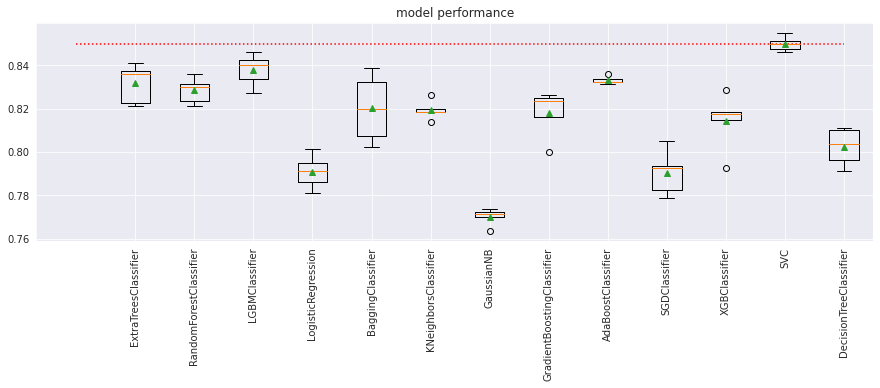

In [26]:
#Melihat performansi model setelah di tuning

t0 = time.time()
tuned_models_dict = get_models(tuned_models)
boxplot_model(tuned_models_dict, X_pca, y)
print('lama waktu eksekusi {:.2f} menit'.format((time.time() - t0) / 60))

In [27]:
#Membuat function yang me-return Model Voting
def HardVoting(top_models, num):
  HV = EnsembleVoteClassifier(top_models[:num], voting='hard')
  return HV
def SoftVoting(top_models, num):
  SV = EnsembleVoteClassifier(top_models[:num], voting='soft')
  return SV

HV_3, HV_5 = HardVoting(rank_models.Model, 3), HardVoting(rank_models.Model, 5)
SV_3, SV_5 = SoftVoting(rank_models.Model, 3), SoftVoting(rank_models.Model, 5)

#Membuat Stacking Model
def StackModel(top_models, num, meta_learner):
  SM = StackingClassifier(classifiers = top_models[:num], meta_classifier=meta_learner,
                          use_probas=True, average_probas=False)
  return SM

SM_4_xgb = StackModel(rank_models.Model, 4, TunedXGBoost)
SM_4_lgb = StackModel(rank_models.Model, 4, TunedLGBoost)

agg_models = [SM_4_xgb, SM_4_lgb, HV_3, HV_5, SV_3, SV_5]

**Membuat class yang menggambarkan**
1. Performansi dari tiap model dalam bentuk
  - confusion matrix
  - kurva ROC dan skor nya
2. Prediktor penting (Feature importance)
3. juga me-restore hasil prediksi dari tiap model untuk kemudian meminta neural_network (meta learner) menjadikannya feature / data training untuk menghasilkan prediksi akhir

In [28]:
class Performansi_model():
  def __init__(self, X, y):
    self.X, self.y = X, y
    self.Xtrain, self.Xtest, self.ytrain, self.ytest = train_test_split(
      self.X, self.y, test_size=.2, stratify=self.y, random_state=2020)
  def confusion_matrix(self, models):
    global test_hard_pred_df, test_soft_pred_df
    test_hard_pred_df, test_soft_pred_df = pd.DataFrame(), pd.DataFrame()

    plt.figure(figsize=(15, 8))
    for label, i, cmap in zip(models, range(len(models)), cmaps):
      cv_score = cross_val_score(models[label], self.Xtrain, self.ytrain, cv=cv, scoring='accuracy').mean()
      models[label].fit(self.Xtrain, self.ytrain) 
      ypred_prob = models[label].predict_proba(self.Xtest)[:, 1]
      fpr, tpr, thresholds = roc_curve(self.ytest, ypred_prob)
      opt_idx = np.argmax(tpr - fpr)
      opt_threshold =  thresholds[opt_idx]      
      ypred = (models[label].predict(self.Xtest) > opt_threshold).astype(int)
      Test_acc = accuracy_score(self.ytest, ypred)
      fig = plt.subplot(5, 5, i+1)
      cm = confusion_matrix(self.ytest, ypred)
      sns.heatmap(cm, annot=True, fmt='d', ax=fig, cmap=cmap)
      fig.set_title('%s \n[acc_test=%.3f]' %(label, Test_acc))
      plt.tight_layout(pad=0)
      if i > 0:
        plt.axis('off')

      #Training model pada full data
      pca = PCA(n_components = X_pca.shape[1])
      dftest_pca = pca.fit_transform(dftest)      
      models[label].fit(self.X, self.y)
      test_hard_pred_df = pd.concat(
        [test_hard_pred_df, pd.DataFrame({label : models[label].predict(dftest_pca)})], 1)
      test_soft_pred_df = pd.concat(
        [test_soft_pred_df, pd.DataFrame({label : models[label].predict_proba(dftest_pca)[:, 1]})], 1)   
         
  def roc_curve(self, models):
    global valid_hard_pred_df, valid_soft_pred_df
    valid_hard_pred_df, valid_soft_pred_df = pd.DataFrame(), pd.DataFrame()

    plt.figure(figsize=(18, 12))
    for label, i, color in zip (models, range(len(models)), colors):
      models[label].fit(self.Xtrain, self.ytrain)
      ypred_prob = models[label].predict_proba(self.Xtest)[:, 1]
      fpr, tpr, thresholds = roc_curve(self.ytest, ypred_prob)
      opt_idx = np.argmax(tpr - fpr)
      opt_threshold =  thresholds[opt_idx]
      auc_score = auc(fpr, tpr)
      ypred = (models[label].predict(self.Xtest) > opt_threshold).astype(int)
      presisi = precision_score(self.ytest, ypred, average='binary')

      valid_hard_pred_df = pd.concat(
        [valid_hard_pred_df, pd.DataFrame({label : ypred})], 1)
      valid_soft_pred_df = pd.concat(
        [valid_soft_pred_df, pd.DataFrame({label : ypred_prob})], 1)

      plt.subplot(5, 4, i + 1)
      plt.plot(fpr, tpr, label='\n[auc_score = %.3f,\npresisi = %.3f]' %(auc_score, presisi), color=color)
      plt.legend(loc='downright', fontsize=12), plt.title('%s'%label)
      plt.tight_layout(pad=0), plt.plot([0, 1], [0, 1], ':k')
      if i % 4 > 0:
        plt.yticks([]), plt.xticks([])
  def feature_importance(self, models):
    plt.figure(figsize=(20, 12))
    for model, i in zip(models, range(len(models))):
      fig = plt.subplot(3, 3, i + 1)
      model.fit(self.Xtrain, self.ytrain)
      if model in tree_base_models:
        feat_imp = pd.Series(model.feature_importances_[:12], X.columns[:12]).sort_values()
        feat_imp.plot(kind = 'barh', title='Feature Importance \n[%s]'%model.__class__.__name__, ax=fig)
        plt.yticks(rotation=0), plt.xticks(rotation=0), plt.tight_layout(pad=0)
      elif model is TunedXGBoost:
        xgb.plot_importance(model, max_num_features=10, ax=fig)
      elif model is TunedLGBoost:
        lgb.plot_importance(model, max_num_features=10, ax=fig)
      else:
        plt.text(0.15, 0.3, '[%s] \ntidak punya atribut\nfeature importance'%model.__class__.__name__,
                 fontsize=14,), plt.axis('off')  

lama waktu eksekusi 0.21 menit


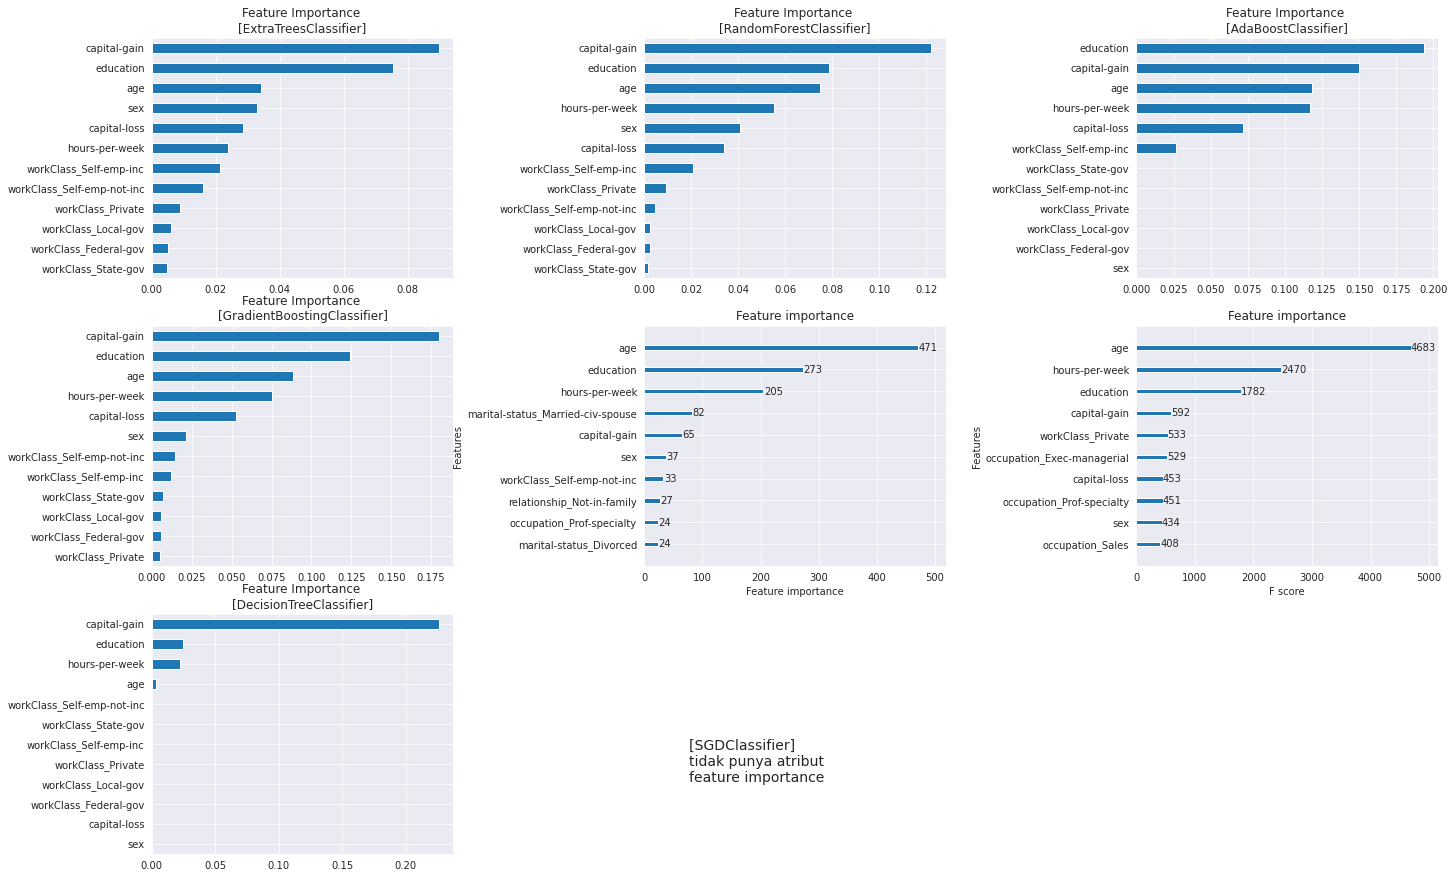

In [29]:
t0 = time.time()
show_1 = Performansi_model(X, y)
show_1.feature_importance([TunedETC, TunedRFC, TunedABC, TunedGBC,
                     TunedLGBoost, TunedXGBoost, TunedDTC, TunedSGD])
print('lama waktu eksekusi {:.2f} menit'.format((time.time() - t0) / 60))

lama waktu eksekusi 1.80 menit


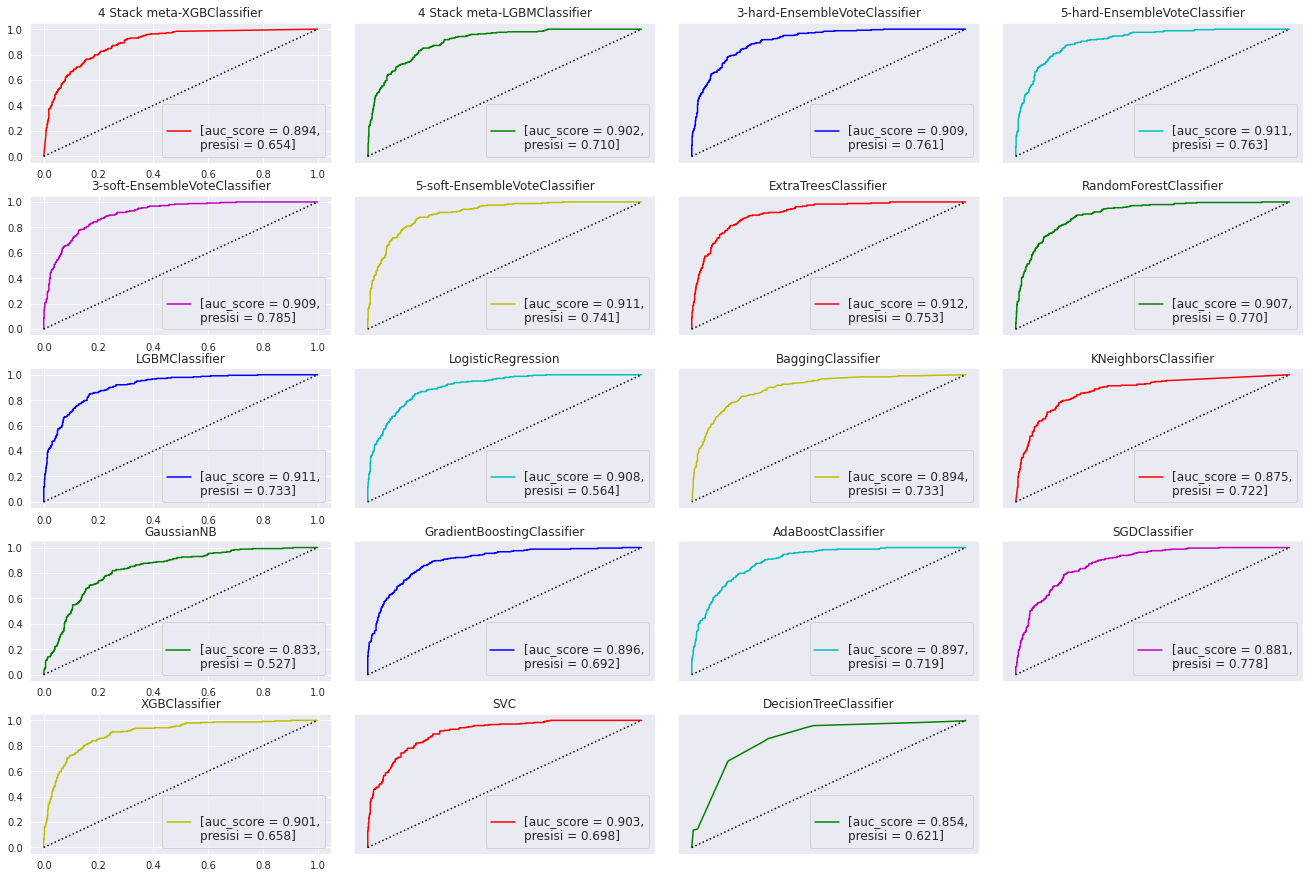

In [30]:
t0 = time.time()
all_models = get_models(agg_models + tuned_models)
show_2 = Performansi_model(X_pca, y)
show_2.roc_curve(all_models)
print('lama waktu eksekusi {:.2f} menit'.format((time.time() - t0) / 60))

lama waktu eksekusi 10.60 menit


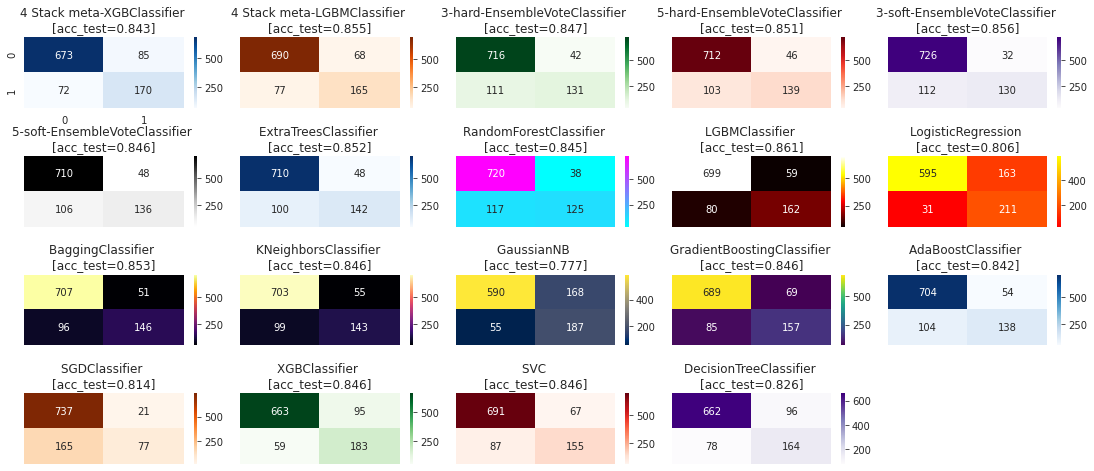

In [31]:
t0 = time.time()
show_3 = Performansi_model(X_pca, y)
show_3.confusion_matrix(all_models)
print('lama waktu eksekusi {:.2f} menit'.format((time.time() - t0) / 60))

lama waktu eksekusi 8.27 menit


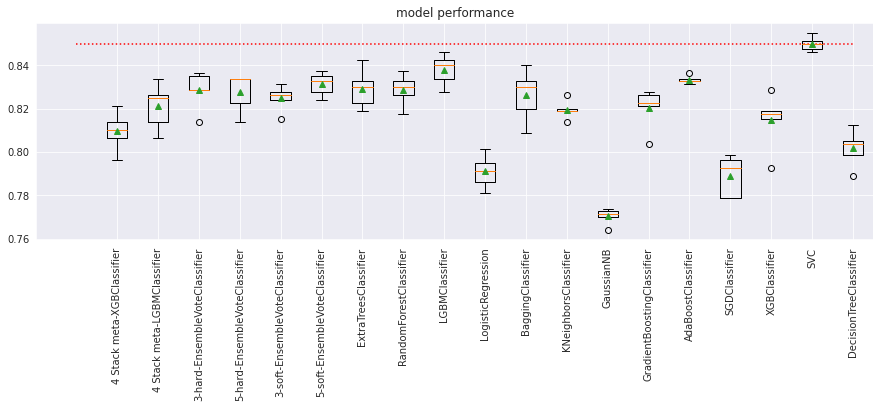

In [32]:
t0 = time.time()
boxplot_model(all_models, X_pca, y)
print('lama waktu eksekusi {:.2f} menit'.format((time.time() - t0) / 60))

In [33]:
#Melihat peringkat model terbaru berdasarkan nilai presisi nya
rank_models.iloc[:, [0, 2, 3, 4]]

,Model Name,Train_CV_acc,Test_acc,Precision Test
0,3-soft-EnsembleVoteClassifier,0.825,0.853,0.795
1,SGDClassifier,0.789,0.812,0.787
2,RandomForestClassifier,0.829,0.847,0.773
3,BaggingClassifier,0.826,0.856,0.763
4,3-hard-EnsembleVoteClassifier,0.828,0.846,0.762
5,5-hard-EnsembleVoteClassifier,0.828,0.855,0.759
6,ExtraTreesClassifier,0.829,0.853,0.749
7,5-soft-EnsembleVoteClassifier,0.831,0.849,0.746
8,LGBMClassifier,0.838,0.861,0.733
9,KNeighborsClassifier,0.819,0.846,0.722


In [34]:
valid_hard_pred_df = valid_hard_pred_df.set_index([Xtest.index])
#valid_hard_pred_df = pd.concat([valid_hard_pred_df, income[Xtest.index]], 1)
valid_soft_pred_df = valid_soft_pred_df.set_index([Xtest.index])
#valid_soft_pred_df = pd.concat([valid_soft_pred_df, income[Xtest.index]], 1)

test_hard_pred_df = test_hard_pred_df.set_index([testdex])
test_soft_pred_df = test_soft_pred_df.set_index([testdex])

In [35]:
#Melihat pendapat (hasil prediksi) dari tiap model

valid_soft_pred_df.sample(5)

,4 Stack meta-XGBClassifier,4 Stack meta-LGBMClassifier,3-hard-EnsembleVoteClassifier,5-hard-EnsembleVoteClassifier,3-soft-EnsembleVoteClassifier,5-soft-EnsembleVoteClassifier,ExtraTreesClassifier,RandomForestClassifier,LGBMClassifier,LogisticRegression,BaggingClassifier,KNeighborsClassifier,GaussianNB,GradientBoostingClassifier,AdaBoostClassifier,SGDClassifier,XGBClassifier,SVC,DecisionTreeClassifier
PersonID,,,,,,,,,,,,,,,,,,,
532,0.125066,0.000729,0.046248,0.043135,0.049350,0.043520,0.034809,0.039431,0.032639,0.105005,0.020000,0.048447,0.013847,0.001644,0.405349,0.069184,0.128820,0.027761,0.012821
3712,0.863394,0.975108,0.661290,0.722217,0.689253,0.723224,0.700363,0.683988,0.929093,0.993708,0.710000,0.658117,0.997277,0.990943,0.568597,0.642977,0.792329,0.986015,0.909910
1462,0.639138,0.543793,0.183319,0.193958,0.190152,0.195877,0.203230,0.121878,0.299764,0.193262,0.165000,0.119518,0.095506,0.034656,0.465610,0.228172,0.296084,0.088980,0.209302
4816,0.372849,0.113632,0.287011,0.258701,0.294127,0.258809,0.294591,0.312415,0.133644,0.402759,0.128333,0.291400,0.025248,0.016670,0.463850,0.283530,0.234138,0.139727,0.291304
4252,0.868948,0.994914,0.769246,0.857545,0.771139,0.854964,0.872039,0.855501,0.969414,0.995760,0.950000,1.000000,0.992447,0.999944,0.580831,0.580184,0.867909,0.995759,0.909910


In [36]:
#Mengambil hasil prediksi hanya dari model yang bukan staking/voting
valid_soft_pred_df_for_stack = valid_soft_pred_df.iloc[:, 6:]
valid_soft_pred_df_for_stack.head()

,ExtraTreesClassifier,RandomForestClassifier,LGBMClassifier,LogisticRegression,BaggingClassifier,KNeighborsClassifier,GaussianNB,GradientBoostingClassifier,AdaBoostClassifier,SGDClassifier,XGBClassifier,SVC,DecisionTreeClassifier
PersonID,,,,,,,,,,,,,
399,0.534942,0.462820,0.652329,0.702363,0.440000,0.483548,0.975420,0.136381,0.504221,0.457094,0.616325,0.321581,0.581673
3834,0.044791,0.054059,0.039649,0.149350,0.030000,0.000000,0.008958,0.002752,0.441189,0.204294,0.133042,0.070058,0.012821
4837,0.772709,0.623740,0.882975,0.986575,0.640000,0.809815,0.976673,0.991367,0.516746,0.561605,0.811309,0.974705,0.581673
4573,0.311513,0.344690,0.369620,0.662707,0.207524,0.280825,0.839891,0.136501,0.490623,0.322294,0.503096,0.465868,0.209302
637,0.041557,0.082170,0.022095,0.173793,0.040000,0.000000,0.000106,0.000757,0.435991,0.156496,0.125371,0.138511,0.012821


In [37]:
#Menggabungkan data test asli dengan hasil prediksi tiap model dari data test asli tsb
Xstack = pd.concat([Xtest, valid_soft_pred_df_for_stack], 1)

ystack = y[Xtest.index]
Xstack_train, Xstack_test, ystack_train, ystack_test = train_test_split(
    Xstack, ystack, test_size=.2, stratify=ystack, random_state=2020)

test_stack = pd.concat([dftest, test_soft_pred_df.iloc[:, 6:]], 1)

 **Membuat model neural_network**
1. Mendefinisikan rentang hyperparameter nya
2. Men-tuning hyperparameter dengan menggunakan Bayesian Optimizer (Hyperoppt)
3. Membangun model neural_network dengan menggunakan hyperparameter yang telah didapatkan

In [38]:
#1. Mendefinisikan rentang hyperparameter nya

search_optimizer = hp.choice('name',
    [
     {'name' :'nadam', 'learning_rate' : hp.loguniform('learning_rate_nadam', np.log(.0001), np.log(.01))},
     {'name' : 'sgd', 'learning_rate' : hp.loguniform('learning_rate_sgd', np.log(.0001), np.log(.01)),
      'momentum' : hp.uniform('momentum_sgd', .9, .96), 'nesterov' : hp.choice('nesterov_sgd',
                                                                               [False, True])}])
search_space = {
    'optimizer' : search_optimizer,
    'layer1_size' : hp.quniform('layer1_size', 32, 523, 32),
    'layer2_size' : hp.quniform('layer2_size', 32, 257, 16),
    'AlphaDropout_rate' : hp.uniform('AlphaDropout_rate1', .05, .2),
    'batch_size' : hp.choice('batch_size', [32, 48, 64])}

In [39]:
#2. Men-tuning hyperparameters neural_network

class BayesianNeuralNetwork():
  def __init__(self, Xtrain, ytrain, Xtest, ytest):
    self.Xtrain, self.ytrain = Xtrain, ytrain
    self.Xtest, self.ytest = Xtest, ytest
  def train_nn(self, hyparams):
    model = Sequential()
    model.add(Dense(units=hyparams['layer1_size'], activation='selu', kernel_initializer='lecun_normal',
                    input_shape = (self.Xtrain.shape[1], )))
    model.add(AlphaDropout(rate=hyparams['AlphaDropout_rate']))
    model.add(Dense(units=hyparams['layer2_size'], activation='selu', kernel_initializer='lecun_normal'))
    model.add(Dense(1, activation='sigmoid'))
    if hyparams['optimizer']['name'] == 'nadam':
      opt = Nadam(lr=hyparams['optimizer']['learning_rate'])
    else:
      opt = SGD(lr=hyparams['optimizer']['learning_rate'], momentum=hyparams['optimizer']['momentum'],
                nesterov = hyparams['optimizer']['nesterov'])
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.fit(self.Xtrain, self.ytrain, epochs=30, batch_size=hyparams['batch_size'],
              validation_split=.2, verbose=0, callbacks = [ReduceLROnPlateau()])
    return model
  def test_nn(self, model):
    test_acc = model.evaluate(self.Xtest, self.ytest)
    return test_acc
  def objective_nn(self, hyparams):
    model = self.train_nn(hyparams)
    test_acc = self.test_nn(model)
    loss = 1 - test_acc[1]
    K.clear_session()
    return {'loss' : loss, 'status' : STATUS_OK}
  def Fmin(self, search_space):
    best = fmin(fn=self.objective_nn, space=search_space, algo=tpe.suggest, max_evals=5)
    best = space_eval(search_space, best)
    for i in best:
      if i in ['layer1_size', 'layer2_size']:
        best[i] = int(best[i])
    return best 

BNN = BayesianNeuralNetwork(Xstack_train, ystack_train, Xstack_test, ystack_test)
best_nn = BNN.Fmin(search_space)
print('Hyperparameters terbaik yang kita dapatkan adalah')
print(best_nn)

1/7 [===>..........................]
 - ETA: 0s - loss: 0.1807 - accuracy: 0.9375

7/7 [==============================]
 - 0s 4ms/step - loss: 0.3219 - accuracy: 0.8700

1/7 [===>..........................]
 - ETA: 0s - loss: 0.1590 - accuracy: 0.9688

7/7 [==============================]
 - 0s 4ms/step - loss: 0.3234 - accuracy: 0.8700

1/7 [===>..........................]
 - ETA: 0s - loss: 0.1576 - accuracy: 0.9688

7/7 [==============================]
 - 0s 4ms/step - loss: 0.3211 - accuracy: 0.8600

1/7 [===>..........................]
 - ETA: 0s - loss: 0.2127 - accuracy: 0.9375

7/7 [==============================]
 - 0s 4ms/step - loss: 0.3641 - accuracy: 0.8550



In [40]:
#3. membangun neural_network dengan hyperparameters yang telah didapatkan diatas
def NN(input_shape, optimizer=best_nn['optimizer']['name']):
  model = Sequential(
      [Dense(int(best_nn['layer1_size']), activation='selu', kernel_initializer='lecun_normal',
             input_shape=(input_shape, )),
       AlphaDropout(rate=best_nn['AlphaDropout_rate']),
       Dense(int(best_nn['layer2_size']), activation='selu', kernel_initializer='lecun_normal'),
       Dense(1, activation='sigmoid')])
  if optimizer == 'nadam':
    model.compile(
        loss='binary_crossentropy', optimizer=Nadam(lr=best_nn['optimizer']['learning_rate']),
        metrics='accuracy')
  else: 
    model.compile(loss='binary_crossentropy', optimizer=SGD(lr=best_nn['optimizer']['learning_rate'],
                                                          momentum=best_nn['optimizer']['momentum'],
                                                          nesterov=best_nn['optimizer']['nesterov']),
                metrics='accuracy')
  return model

#3. training neural_network
def fit_nn(Xtrain, ytrain, Xtest, ytest, model):
  fig, ax = plt.subplots(1, 2, figsize=(18, 5))
  hist = model.fit(
      Xtrain, ytrain, validation_split=.2, epochs=20,
      callbacks = [ReduceLROnPlateau(), EarlyStopping(patience=9, restore_best_weights=True, 
                                                      monitor='val_accuracy')],
      batch_size = best_nn['batch_size'], verbose=1)
  pd.DataFrame(hist.history).loc[:, ['loss', 'val_loss']].plot(ax = ax[1])
  pd.DataFrame(hist.history).loc[:, ['accuracy', 'val_accuracy']].plot(ax = ax[0])
  final_loss, final_acc = model.evaluate(Xtest, ytest)
  ax[0].set_title('final accuracy = {:.3f}'.format(final_acc))
  ax[1].set_title('final loss = {:.3f}'.format(final_loss))
  plt.ylim(0, 1)

Epoch 1/20
20/20 [==============================] - 0s 10ms/step - loss: 0.6508 - accuracy: 0.6562 - val_loss: 0.3468 - val_accuracy: 0.8625
Epoch 2/20
20/20 [==============================] - 0s 2ms/step - loss: 0.4456 - accuracy: 0.7859 - val_loss: 0.3253 - val_accuracy: 0.8562
Epoch 3/20
20/20 [==============================] - 0s 3ms/step - loss: 0.4159 - accuracy: 0.8062 - val_loss: 0.3022 - val_accuracy: 0.8687
Epoch 4/20
20/20 [==============================] - 0s 2ms/step - loss: 0.4110 - accuracy: 0.8031 - val_loss: 0.3259 - val_accuracy: 0.8687
Epoch 5/20
20/20 [==============================] - 0s 2ms/step - loss: 0.3977 - accuracy: 0.8016 - val_loss: 0.3133 - val_accuracy: 0.8750
Epoch 6/20
20/20 [==============================] - 0s 3ms/step - loss: 0.3981 - accuracy: 0.8141 - val_loss: 0.3294 - val_accuracy: 0.8750
Epoch 7/20
20/20 [==============================] - 0s 2ms/step - loss: 0.3673 - accuracy: 0.8234 - val_loss: 0.3241 - val_accuracy: 0.8750
Epoch 8/20
20/20 [=

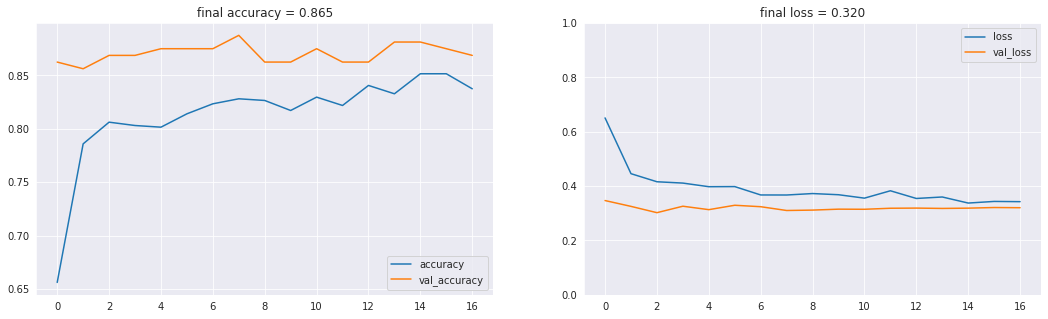

In [41]:
#Melihat performa dari model yang baru saja kita buat

K.clear_session()
nn = NN(Xstack.shape[1], best_nn['optimizer']['name'])
fit_nn(Xstack_train, ystack_train, Xstack_test, ystack_test, nn)

In [42]:
test_soft_pred_df['neural_network'] = np.round(nn.predict(test_stack), 3)

test_hard_pred_df['nn'] = np.round(nn.predict(test_stack), 3)
test_hard_pred_df['neural_network'] = 0
test_hard_pred_df.loc[test_hard_pred_df['nn'] > 0.5, ['neural_network']] = 1

test_hard_pred_df.drop('nn', 1, inplace=True)

In [43]:
#Membuat kolom neural_network ada di paling depan biar kelihatan ^_^
test_soft_pred_df = pd.concat([test_soft_pred_df.loc[:, ['neural_network']],
                               test_soft_pred_df.iloc[:, :-1]], 1)

test_hard_pred_df = pd.concat([test_hard_pred_df.loc[:, ['neural_network']],
                               test_hard_pred_df.iloc[:, :-1]], 1)
test_soft_pred_df.sample(5)

,neural_network,4 Stack meta-XGBClassifier,4 Stack meta-LGBMClassifier,3-hard-EnsembleVoteClassifier,5-hard-EnsembleVoteClassifier,3-soft-EnsembleVoteClassifier,5-soft-EnsembleVoteClassifier,ExtraTreesClassifier,RandomForestClassifier,LGBMClassifier,LogisticRegression,BaggingClassifier,KNeighborsClassifier,GaussianNB,GradientBoostingClassifier,AdaBoostClassifier,SGDClassifier,XGBClassifier,SVC,DecisionTreeClassifier
PersonID,,,,,,,,,,,,,,,,,,,,
6940,0.003,0.125022,0.000668,0.090551,0.049537,0.097355,0.052373,0.068676,0.202227,0.008513,0.005555,0.275000,0.000000,0.023325,0.008555,0.380192,0.000000,0.187047,0.001839,0.022607
5475,0.299,0.143344,0.032389,0.269154,0.249334,0.276811,0.267009,0.239448,0.262866,0.252686,0.269838,0.255000,0.255845,0.113604,0.089366,0.482473,0.309530,0.276378,0.061054,0.645638
5413,0.019,0.125022,0.000703,0.045316,0.029698,0.039940,0.029533,0.055777,0.085864,0.007748,0.009437,0.120000,0.000000,0.000490,0.002681,0.378611,0.000000,0.161065,0.001734,0.022607
6881,0.637,0.365210,0.484906,0.300024,0.349615,0.290897,0.353583,0.277192,0.315711,0.461356,0.404553,0.337333,0.381970,0.012540,0.283286,0.478392,0.294562,0.377412,0.106345,0.393939
6176,0.322,0.654157,0.390874,0.391985,0.365622,0.378560,0.361557,0.432186,0.329701,0.159937,0.002858,0.456667,0.566858,1.000000,0.686698,0.455690,0.387589,0.435406,0.000131,0.286325


**Submission**

In [44]:
test_soft_pred_df.to_csv('Cencus_soft.csv', encoding='utf-8')
test_hard_pred_df.to_csv('Cencus_hard.csv', encoding='utf-8')

In [45]:
print('total waktu notebook ini berjalan {:.2f} menit'.format((time.time() - mulai) / 60))

total waktu notebook ini berjalan 28.99 menit


**REFLEKSI** 

- 5 faktor yang dianggap paling berpengaruh menentukan pendapatan sesorang (apakah < 50k atau lebih) adalah
  1. capital-gain
  2. education
  3. sex
  4. age
  5. hours per week
- nilai presisi tertinggi yang didapatkan adalah 0,793 dan ini diraih oleh model 3-soft-EnsembleVoteClassifier
- meski sudah men-tuning hyperparameter nya dengan menggunakan hyperopt, tampaknya model improvement nya tak cukup berarti ^_^
- kalau begitu, rentang hyperparameter nya seharusnya dibuat lebih lebar lagi atau tingkatkan nilai dari max_evals pada fungsi fmin nya

In [47]:
print('Terima Kasih \U0001F600')

Terima Kasih 😀
